This work is greatly inspired by [Cellular Automata as a Language for Reasoning](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning), [Simple and Interactive visualization of tasks](https://www.kaggle.com/bsridatta/simple-and-interactive-visualization-of-tasks#Interactive-visualization), and [Training Cellular Automata Part I: Game of Life](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life). Great thanks to all the great works!

# Key Points 

This notebook

1. Proposed a DSL to describe Cellular Automata rules in a simple, plain-text format like
    
        x x x
        r g b -> b
        r r r
    
2. Created a interactive tool for fast CA experiment. Simply type in your rules and see how it works.

<p><font color="red" size=3>If you like my work please upvote this kernel. It encorages me to produce more quality content!</font></p>



# Intro

Since Cellular Automata(CA) could be a powerful tool to solve this task, this notebook is to provide a way leading to CA-based Domain Specific Languages (DSLs) which is likely easily simulated or synthesized by machine learning models. If you don't have the knowledge of CA, [Cellular Automata as a Language for Reasoning](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) is a greate introduction. 

# Rule Format

## Basic Format

To step further, this notebook is an exploration in developing a DSL with more regular and less number of syntax rules. Rather than write CA rules in pure Python code, a CA rule can be written in a form like

    x x x
    x x x, m -> o, n
    x x x

On the left hand of the arrow, the 3x3 array is a filter to match a 3x3 neighbor area around the central point (maybe 5x5 would be more powerful?), and `m` after the comma is a memory used in [Cellular Automata as a Language for Reasoning](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) to expand the capability of CA. On the right side of the arrow, `o` is the output and `n` is the updated memory. This rule simply means "when the 3x3 neighbor area matches the template and the memory equals the given value, change the value of the central point to `o` and update the memory at this place to `n`". Of course we can omit the memory part, which implies we are not comparing the memory value and not updating it. 

Simple wildcard is useful and will be supported, like a dot(`.`) means matching any value.

## Transform of Filters

To let us write less number of rules, we introduce the transform of filters. To explain this, let's take a simple example: if the value at any of the four corners are 0, change it to 1. For the case of top-left corner, it's easy to be written as

    # # #
    # 0 . -> 1
    # . .
 
where `#` means out-of-border and `.` means "any value". However, we need to repeat 3 more times to write rules for another corners.

However, the filters for other 3 corners are merely rotations of that for top-left corner. If we introduce a concept of "rotation" we can unify the four rules into one, like

         # # #
    [R4] # 0 . -> 1
         # . .
         
where `R4` means a rotation with number 4 (rotation in 90 degrees results in 4 distint filters).

## Syntax List

All the syntax of the DSL introduced in this work are listed as follows:

A CA rule is in form of

        x x x
    [T] x x x, m -> o, n
        x x x

where `T` is the transform, 3x3 `x`s are the template, `m` is memory input, `o` is output, and `n` is memory update. `T`, `m` and `n` can be optional. When no `T` is presented, the default is no transform, i.e. exact match.

### Memory

Only integer values are supported in memory at this point, and only the value in memory at the central point is considered (not its neighborhood). It could be useful if we take into account the same neighbor region in memory as in the state, as a future work.

### Transforms

Supported `T`s:

- `I`: fixed filter, i.e. exact match, the default value

- Histogram: only the count of certain values matters (the location is irrelevant). 
  + `H` histogram includes the central point. 
  + `HN` only compares the histogram of 8 values in the neighborhood and the central value should be exact match. 
  + `HD` is like `HN` but only takes into account the 4-direct neighbor values(i.e. the values at 4 corners are not compared).

- rotations and flips(mirrors): `R8`, `R4`, `R2`, `L8`, `L4`, `L2`, `FH`, `FV`, `FD`, `FA`, `R8F`, `R4F`, `R2F`, `L8F`, `L4F`, `L2F`
  + `R`, `L` means left or right rotation, respectively
  + the number means the angle of rotations, 8 means 45 degrees (resulting in 8 distinct rotations), 4 means 90 degree, and 2 means 180 degree. So infact `R2 == L2`. However, if the filter itself has a certain symmetric property, the result will be less than the number indicated. E.g. the 90 degrees rotation of a filter equals itself, so `R8` only ends up with 2 filters.
  + `F` means flip (mirror), while `H`, `V`, `D`, `A` means horizontal, vertical, diagonal (top left to bottom right), anti-diagonal (top right to bottom left)
  + the suffix `F` in any `R` or `F` means also including the rotations of the mirror of the filter. 

### Filter

 For the values in a filter, some special values are defined:
 
 - `#`: out of border
 - `.`: any value include out-of-border
 
 Some other values might be also useful but not supported yet, like: `*` any value inside the border;
 `+` any value but black (0). Apparently we can introduce more complex syntax leading to a regex-like rules, and this is a trade-off between capability and simplicity.
 
 And the color values are defined as follows. Both index and code are supported, e.g. either `0` or `k` can be used for "black".


In [ ]:
#               0        1       2      3        4         5       6         7         8        9
color_codes = ['k',     'b',    'r',   'g',     'y',      'e',    'p',      'o',      'z',     'n']
color_names = ['black', 'blue', 'red', 'green', 'yellow', 'grey', 'purple', 'orange', 'azure', 'brown']

# Interactive Tool

In order to experiment rules more easily, an interactive UI is created in this notebook which eventually looks like this. It's base on the work of [Simple and Interactive visualization of tasks](https://www.kaggle.com/bsridatta/simple-and-interactive-visualization-of-tasks#Interactive-visualization), plus the rules editing and animation. To use this please go to section [Interactive CA Tool](#Interactive-CA-Tool)(maybe you need to run the notebook before able to see it), simply select the data sample, type your rules in the format defined above in the "rules_txt" input box, and click "Run interact" to see how the rule works.

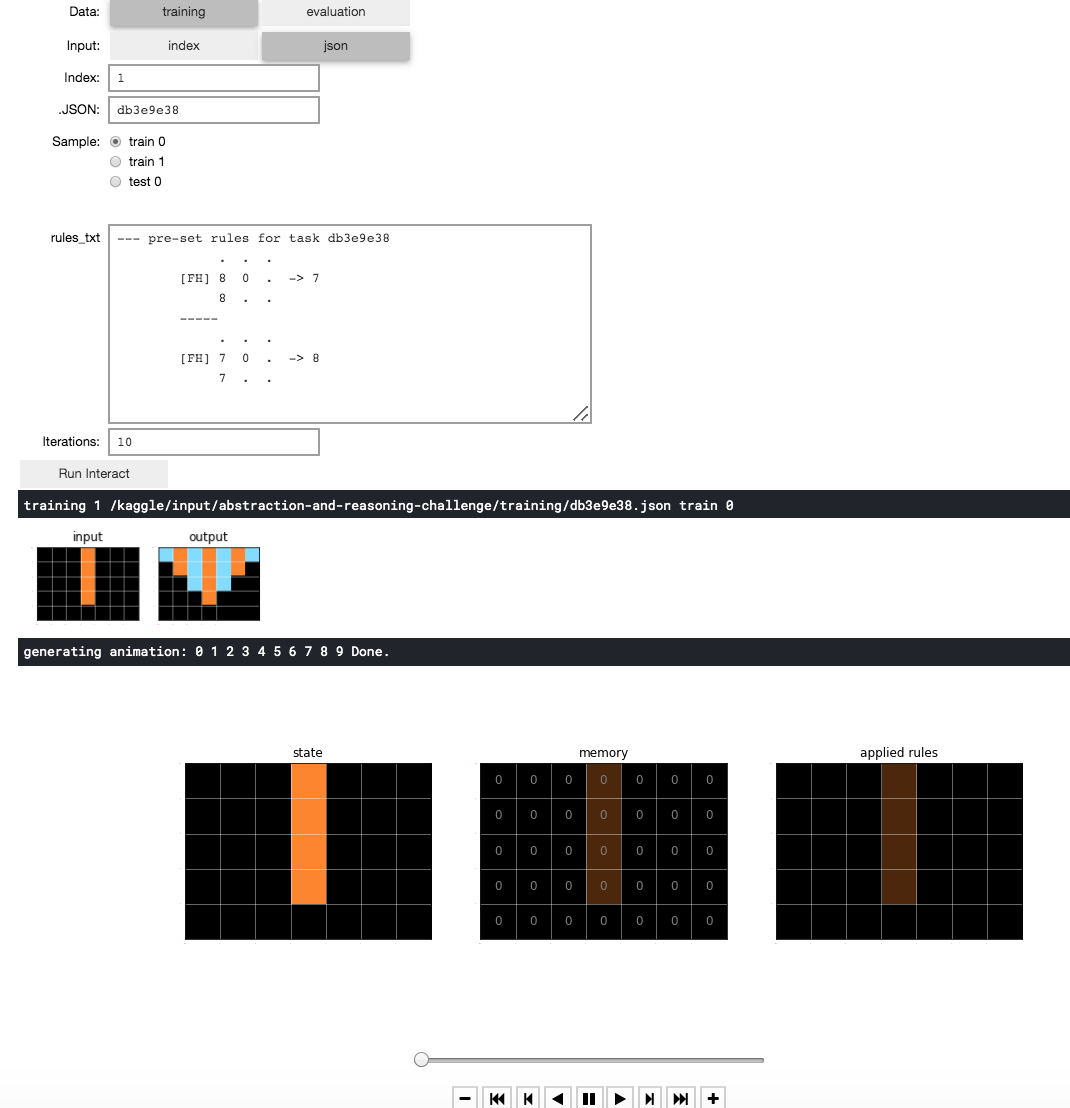

If you want a quick look about the animation, please refer to [this section](#Visualization-&-Animation) for an animation example.

# Implementation

OK, now let's do this.

Import & setup, and create functions for loading and ploting data. This part is mostly from [Simple and Interactive visualization of tasks](https://www.kaggle.com/bsridatta/simple-and-interactive-visualization-of-tasks#Interactive-visualization)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout

from matplotlib import pyplot as plt
from matplotlib import colors, animation

from IPython.display import HTML

import numpy as np

from itertools import product

import os
import json

!jupyter nbextension enable --py widgetsnbextension

root_dir = '/kaggle/input/abstraction-and-reasoning-challenge'
training_files = sorted(os.listdir(f"{root_dir}/training/"))
evaluation_files = sorted(os.listdir(f"{root_dir}/evaluation/"))
test_files = sorted(os.listdir(f"{root_dir}/test/"))

In [ ]:
arc_colors =  ['#000000', "#0074D9", "#FF4136", "#2ECC40", '#FFDC00', "#AAAAAA", '#F012BE', '#FF851B', '#7FDBFF', "#870C25"]
# dark_colors are just a "darker" version of arc_colors (30% percent) to display as "background"
dark_colors = ['#000000', '#002241', '#4c1310', '#0d3d13', '#4c4200', '#333333', '#480539', '#4c2708', '#26414c', '#28030b']
cmap = colors.ListedColormap(arc_colors)
dark_cmap = colors.ListedColormap(dark_colors)
norm = colors.Normalize(vmin=0, vmax=9)

def load_data(path):
    with open(path) as file:
        data = json.load(file)
    return data

# method called by the interact cell
def plot_data(path):
    data = load_data(path)
        
    n_train = len(data['train'])
    fig, axs = plt.subplots(2, n_train+1, figsize=(8,4))
    
    for x in axs:
        for y in x:    
            y.grid(b=True)
            y.tick_params(direction='out', length=0, width=0, colors='r',
                          labelsize=0, grid_color='w', grid_alpha=0.5)

    for i in range(0, n_train): 
        # Train Input
        axs[0,i].imshow(data['train'][i]['input'], cmap=cmap, norm=norm)
        # To fix misalignment of grid and image caused by the pixel snapping issue in matplotlib
        axs[0,i].set_xticks(np.array(range(len(data['train'][i]['input'][0])))-0.5)
        axs[0,i].set_yticks(np.array(range(len(data['train'][i]['input'])))-0.5)
        # Train Output
        axs[1,i].imshow(data['train'][i]['output'], cmap=cmap, norm=norm)
        axs[1,i].set_xticks(np.array(range(len(data['train'][i]['output'][0])))-0.5)
        axs[1,i].set_yticks(np.array(range(len(data['train'][i]['output'])))-0.5)
    # Test Input
    axs[0,n_train].imshow(data['test'][0]['input'], cmap=cmap, norm=norm)
    axs[0,n_train].set_xticks(np.array(range(len(data['test'][0]['input'][0])))-0.5)
    axs[0,n_train].set_yticks(np.array(range(len(data['test'][0]['input'])))-0.5)
    # Test output
    axs[1,n_train].imshow(data['test'][0]['output'], cmap=cmap, norm=norm)
    axs[1,n_train].set_xticks(np.array(range(len(data['test'][0]['output'][0])))-0.5)
    axs[1,n_train].set_yticks(np.array(range(len(data['test'][0]['output'])))-0.5)

    # separator
    axs[0,n_train].plot([-0.1, -0.1], [0,1], color='grey', lw=3, transform=axs[0,n_train].transAxes, clip_on=False)
    axs[1,n_train].plot([-0.1, -0.1], [0,1], color='grey', lw=3, transform=axs[1,n_train].transAxes, clip_on=False)

    axs[0,0].set_ylabel('input')
    axs[1,0].set_ylabel('output')
    
    plt.show()

# Implementation of Filters

Now lets create a variety of kinds of filters. Here we got

- `I`: `FixedFilter`
- `H`: `HistFilter`
- `HN`: `NeighHistFilter`
- `HD`: `DirectNeighHistFilter`
- Rotations and flips: `TransFilter` working with a bunch of rotation and flip functions

Note the values in the filter and state is represented as string even it's a number in the dataset, i.e., it's string `"1"` instead of integer `1`.

In [ ]:
OUT_OF_BORDER = '#'
WILD_CARD = '.'
ca_dtype = np.dtype('<U1')

class FilterBase(object):

    def match(self, feature):    
        raise NotImplementedError('')

    def shape(self):
        raise NotImplementedError('')
    
class FixedFilter(FilterBase):
    
    def __init__(self, filt):
        self._filter = np.array(filt, dtype=ca_dtype)
        self._valid_pos = self._filter != WILD_CARD
        self._valid_filt = self._filter[self._valid_pos]
    
    def __repr__(self):
        return 'I(' + repr(self._filter) + ')'
    
    def shape(self):
        return self._filter.shape
    
    def match(self, feature):
        if feature.shape != self._filter.shape:
            raise ValueError('filter and feature size dont match: {}, {}'.format(self._filter.shape, feature.shape))
        return np.all(feature[self._valid_pos] == self._valid_filt)

def cal_hist(arr):
    val, cnt = np.unique(arr, return_counts=True)
    hist = dict(zip(val, cnt))
    #print('hist', filt, hist)
    return hist

class HistFilter(FilterBase):
    
    def __init__(self, filt):
        self._filter = np.array(filt, dtype=ca_dtype)
        w, h = self._filter.shape
        self._hist = self._cal_hist(self._filter)
        if WILD_CARD in self._hist:
            del self._hist[WILD_CARD]
        
    def _cal_hist(self, filt):
        return cal_hist(filt)
    
    def __repr__(self):
        return 'H(' + repr(self._hist) + ')'
    
    def shape(self):
        return self._filter.shape
    
    def match(self, feature):
        fhist = self._cal_hist(feature)
        #print('hist filter', self._hist, fhist)
        for k, v in self._hist.items():
            if k not in fhist or fhist[k] < v:
                return False
        return True

class NeighHistFilter(HistFilter):
    
    def __init__(self, filt):
        w = len(filt[0])
        h = len(filt)
        #print(w, h)
        self._center_x = w // 2
        self._center_y = h // 2
        super().__init__(filt)
        self._c = self._filter[self._center_x, self._center_y]
        if self._c != WILD_CARD and self._hist[self._c] == 0:
            del self._hist[self._c]
        
    def _cal_hist(self, filt):
        hist = cal_hist(filt)
        #print(hist)
        c = filt[self._center_x, self._center_y]
        hist[c] -= 1
        #print(hist)
        return hist

    def __repr__(self):
        return 'HN(hist=' + repr(self._hist) + ', center=' + repr(self._c) + ')'
    
    def match(self, feature):
        c = feature[self._center_x, self._center_y]
        if self._c == WILD_CARD or self._c == c:
            return super().match(feature)
        return False

class DirectNeighHistFilter(HistFilter):
    
    def __init__(self, filt):
        w = len(filt[0])
        h = len(filt)
        #print(w, h)
        self._center_x = xc = w // 2
        self._center_y = yc = h // 2
        self._pos = [(xc + dx, yc + dy) for dx, dy in \
                     [(-1, 0), (1, 0), (0, -1), (0, 1)]]
        self._bool_idx = np.zeros((3, 3), dtype=bool)
        for i, j in self._pos:
            self._bool_idx[i, j] = True
        #print(self._bool_idx)
        super().__init__(filt)
        self._c = self._filter[self._center_x, self._center_y]
        
    def _cal_hist(self, filt):
        vals = cal_hist(filt[self._bool_idx])
        return vals

    def __repr__(self):
        return 'HD(hist=' + repr(self._hist) + ', center=' + repr(self._c) + ')'
    
    def match(self, feature):
        c = feature[self._center_x, self._center_y]
        if self._c == WILD_CARD or self._c == c:
            return super().match(feature)
        return False

def iter_array_indices(arr):
    h, w = arr.shape
    return product(range(h), range(w))
    
def get_array_indices(arr):
    return list(iter_array_indices(arr))

def reshape_like(arr1d, ref):
    return arr1d.reshape(ref.shape)

def get_array_indices_2d(arr):
    h, w = arr.shape
    idx = []
    for i in range(h):
        idx.append([(i, j) for j in range(w)])
    idx = np.array(idx, dtype=np.int)
    #print('index of array: ', arr, idx)
    return idx

def coord_rotate_right_90(x, y):
    return -y, x
def coord_rotate_left_90(x, y):
    return y, -x
def coord_rotate_180(x, y):
    return -x, -y
def coord_rotate_right_45(x, y):
    if x == y:
        return 0, y
    elif x == -y:
        return x, 0
    elif x == 0:
        return -y, y
    elif y == 0:
        return x, x
def coord_rotate_left_45(x, y):
    if x == y:
        return x, 0
    elif x == -y:
        return 0, y
    elif x == 0:
        return y, y
    elif y == 0:
        return x, -x
def coord_flip_horiz(x, y):
    return -x, y
def coord_flip_verti(x, y):
    return x, -y
def coord_flip_diag(x, y):
    return y, x
def coord_flip_anti_diag(x, y):
    return -y, -x

def trans_array(arr, coord_target):
    h, w = arr.shape
    if h != 3 or w != 3:
        raise ValueError('only support 3x3 array at this point')
    ret = np.zeros_like(arr)
    ci, cj = h // 2, w // 2  # center point
    rh, rw = ci, cj
    for y, x in product(range(-rh, rh+1), range(-rw, rw+1)):
        i, j = ci + y, cj + x
        dst_x, dst_y = coord_target(x, y)
        dst_i, dst_j = ci + dst_y, cj + dst_x
        #i, j, dst_i, dst_j = i//2, j//2, dst_i//2, dst_j//2
        #print(x, y, ' --> ', dst_x, dst_y, ' | ', i, j, ' --> ', dst_i, dst_j)
        ret[dst_i, dst_j] = arr[i, j]
    return ret

rotate_right_45 = lambda a: trans_array(a, coord_rotate_right_45)
rotate_left_45 = lambda a: trans_array(a, coord_rotate_left_45)
rotate_right_90 = lambda a: trans_array(a, coord_rotate_right_90)
rotate_left_90 = lambda a: trans_array(a, coord_rotate_left_90)
rotate_180 = lambda a: trans_array(a, coord_rotate_180)
flip_horiz = lambda a: trans_array(a, coord_flip_horiz)
flip_verti = lambda a: trans_array(a, coord_flip_verti)
flip_diag = lambda a: trans_array(a, coord_flip_diag)
flip_anti_diag = lambda a: trans_array(a, coord_flip_anti_diag)

def trans_iter(trans, flip=False):
    def _iter(arr):
        seeds = [arr]

        if flip:
            ff = flip_diag(arr)
            # if array is symmetric, the flipped array and all its rotations 
            # will be included in the rotations of the array itself.
            if np.any(ff != arr) and np.any(arr != flip_horiz(arr)) \
                    and np.any(arr != flip_verti(arr)) \
                    and np.any(arr != flip_anti_diag(arr)):
                seeds.append(ff)

        #print('seeds', seeds)
        for seed in seeds:
            t = seed
            while True:
                yield t
                t = trans(t)
                if any(np.all(t == s) for s in seeds):
                    break
    return _iter

a = np.arange(9).reshape((3,3))
a = np.array([[0, 1, 2], [3, 5, 3], [2, 1, 0]])
a = np.array([[2, 1, 2], [3, 5, 3], [1, 4, 1]])
#a = np.array([[0, 1, 0], [1, 5, 1], [0, 1, 0]])
print(a)
# print(rotate_right_45(a))
# print(rotate_left_45(a))
# print(rotate_right_90(a))
# print(rotate_left_90(a))
# print(rotate_180(a))
# print(flip_horiz(a))
# print(flip_verti(a))
# print(flip_diag(a))
# print(flip_anti_diag(a))

# print(list(trans_iter(rotate_right_45)(a)))
# print(list(trans_iter(rotate_left_45)(a)))
# print(list(trans_iter(rotate_right_45, flip=True)(a)))
# print(list(trans_iter(rotate_left_45, flip=True)(a)))
# print(list(trans_iter(flip_horiz, True)(a)))

class TransFilter(FilterBase):
    def __init__(self, filt, trans_iter):
        self._filter = self._filter = np.array(filt, dtype=ca_dtype)
        self._trans_iter = trans_iter
        self._equivs = self._cal_equivs(self._filter)
        self._equivs_pos = [e != WILD_CARD for e in self._equivs]
        self._equivs_to_compare = [e[p] for e, p in zip(self._equivs, self._equivs_pos)]
    
    def _cal_equivs(self, filt):
        idx_list = list(self._trans_iter(filt))
        return idx_list
    
    def shape(self):
        return self._filter.shape
    
    def match(self, feature):
        for eq, pos in zip(self._equivs_to_compare, self._equivs_pos):
            feat_to_compare = feature[pos]
            #print('compare', eq, feat_to_compare, 'pos')
            #print(pos)
            if np.all(eq == feat_to_compare):
                return True
            #print('not equal')
        return False
        
    def __repr__(self):
        return 'TF(' + repr(self._equivs) + ')'

def create_filter(filt_type, filt):
    try:
        filt = np.array(filt, dtype=ca_dtype)
    except:
        print('invalid filter: ' + repr(filt))
        raise
        
    if filt_type == 'I':
        return FixedFilter(filt)
    elif filt_type == 'H':
        return HistFilter(filt)
    elif filt_type == 'HN':
        return NeighHistFilter(filt)
    elif filt_type == 'HD':
        return DirectNeighHistFilter(filt)
    elif filt_type == 'R8':
        return TransFilter(filt, trans_iter(rotate_right_45, flip=False))
    elif filt_type == 'R4':
        return TransFilter(filt, trans_iter(rotate_right_90, flip=False))
    elif filt_type == 'R2':
        return TransFilter(filt, trans_iter(rotate_180, flip=False))
    elif filt_type == 'L8':
        return TransFilter(filt, trans_iter(rotate_left_45, flip=False))
    elif filt_type == 'L4':
        return TransFilter(filt, trans_iter(rotate_left_90, flip=False))
    elif filt_type == 'L2':
        return TransFilter(filt, trans_iter(rotate_180, flip=False))
    elif filt_type == 'R8F':
        return TransFilter(filt, trans_iter(rotate_right_45, flip=True))
    elif filt_type == 'R4F':
        return TransFilter(filt, trans_iter(rotate_right_90, flip=True))
    elif filt_type == 'R2F':
        return TransFilter(filt, trans_iter(rotate_180, flip=True))
    elif filt_type == 'L8F':
        return TransFilter(filt, trans_iter(rotate_left_45, flip=True))
    elif filt_type == 'L4F':
        return TransFilter(filt, trans_iter(rotate_left_90, flip=True))
    elif filt_type == 'L2F':
        return TransFilter(filt, trans_iter(rotate_180, flip=True))
    elif filt_type == 'FH':
        return TransFilter(filt, trans_iter(flip_horiz))
    elif filt_type == 'FV':
        return TransFilter(filt, trans_iter(flip_verti))
    elif filt_type == 'FD':
        return TransFilter(filt, trans_iter(flip_diag))
    elif filt_type == 'FA':
        return TransFilter(filt, trans_iter(flip_anti_diag))
    else:
        raise ArgumentError('unknown filter type ' + filt_type)

# filt = np.array([[0, '1', 0], ['1', '#', '1'], ['.', '.', '.']], dtype=ca_dtype)
# filt = np.array([[0, '.', 0], ['.', '0', '.'], ['.', '.', '#']], dtype=ca_dtype)
filt = np.array([['.', '.', 0], ['.', '0', '.'], ['#', '.', '0']], dtype=ca_dtype)
# filt = np.array([[0, '#', 1], ['2', '0', '#'], [2, 1, 0]], dtype=ca_dtype)
print(filt)
ff = create_filter('I', filt)
hf = create_filter('HN', filt)
df = create_filter('HD', filt)
r4 = create_filter('R4', filt)
print(r4)
feat1 = np.array([[0, 1, 0], ['a', '#', 0], [1, 1, 1]], dtype=ca_dtype)
feat2 = np.array([[0, '#', 0], ['#', '0', 1], [0, 2, '#']], dtype=ca_dtype)
print(feat1)
print(ff.match(feat1))
print(hf.match(feat1))
print(df.match(feat1))
print(feat2)
print(ff.match(feat2))
print(hf.match(feat2))
print(df.match(feat2))
print(r4.match(feat2))

# Implementation of CA

OK, now let's create the transition(or step) function of CA based on the filters above. A CA is a list of rules (first rules first matched; once get one matched, skip the rest)

In [ ]:
mem_dtype = np.int

def chunk_list(lst, sep, remove_empty=True):
    ck = []
    for e in lst:
        if sep(e):
            if not remove_empty or len(ck) > 0:
                yield ck
            ck = []
        else:
            ck.append(e)
    if not remove_empty or len(ck) > 0:
        yield ck
    
def remove_invalid(lines):
    return (x for x in \
                (line.strip() for line in lines) \
                if len(x) > 0)

color_code_mapping = { c:str(i) for i, c in enumerate(color_codes) }

def parse_elem(x):
    x = x.strip()
    return color_code_mapping.get(x, x)

def parse_mem_elem(x):
    return int(x)

class CABase(object):
    
    def __init__(self):
        self.reset_memory()
    
    def reset_memory(self):
        self._memory = None
    
    def extract(self, state, i, j):
        pass
    def apply(self, feature, memory):
        pass
    
    def run(self, state, n_iter=10):
        s = state
        for i in n_iter:
            s = self.step(s)
        return s

    def step(self, state):
        if self._memory is None:
            self._memory = np.zeros_like(state, dtype=mem_dtype)
        new_state, self._memory = self._step(state, self._memory)
        return new_state

    def updates(self, state, memory):
        w, h = state.shape
        for i in range(w):
            for j in range(h):
                ns = self.extract(state, i, j)
                ret = self.apply(ns, memory[i, j])
                if ret is not None:
                    yield i, j, ret[0], ret[1]
        
    def _step(self, state, memory):
        #print(state, memory)
        w, h = state.shape
        new_state = np.array(state, dtype=ca_dtype)
        new_memory = np.array(memory, dtype=mem_dtype)
        for i, j, s, m in self.updates(state, memory):
            new_state[i, j] = s
            new_memory[i, j] = m
        return new_state, new_memory

class CALambda(CABase):
    def __init__(self, extract, apply):
        super().__init__()
        self._extract = extract
        self._apply = apply
        
    def extract(self, state, i, j):
        return self._extract(state, i, j)
    
    def apply(self, feature, memory):
        return self._apply(feature, memory)
    
class CAFilter(CABase):
    def __init__(self, filt, out, mem_in=None, mem_out=None):
        super().__init__()
        self._filter = filt
        self._out = out
        self._mem_in = mem_in
        self._mem_out = mem_out
        self._w, self._h = self._filter.shape()
        self._feat_center_x = self._w // 2
        self._feat_center_y = self._h // 2
        
    def __repr__(self):
        return repr([self._filter, ', mem_in=' + repr(self._mem_in), \
                ' -> out=' + repr(self._out), ', mem_out=' + repr(self._mem_out)])
    
    def shape(self):
        return self._filter.shape()
    
    def extract(self, state, i, j):
        feat = np.zeros(self._filter.shape(), dtype=ca_dtype)
        w, h = state.shape
        for xf in range(self._w):
            for yf in range(self._h):
                xs = i - (self._feat_center_x - xf)
                ys = j - (self._feat_center_y - yf)
                #print(xf, yf, '-->', xs, ys)
                if xs >= 0 and xs < w and ys >= 0 and ys < h:
                    feat[xf, yf] = state[xs, ys]
                else:
                    feat[xf, yf] = OUT_OF_BORDER
        #print('feature at ', i, j, ':', feat)
        return feat
    
    def apply(self, feature, memory):
        #print(feature, memory)
        #print(self._valid_pos)
        #print(self._valid_filt)
        if self._filter.match(feature) \
                and (self._mem_in is None or self._mem_in == memory):
            out = feature[self._feat_center_x, self._feat_center_y] if self._out == WILD_CARD else self._out
            mem_out = memory if self._mem_out is None else self._mem_out
            return out, mem_out
        return None
    
    @staticmethod
    def parse_lines(lines):
        #print(lines)
        if len(lines) == 3:
            filt = []
            filt.append([parse_elem(i) for i in lines[0].strip().split()])
            
            # middle line contains condition on memory and the output
            filt_type = 'I'
            tmp = lines[1].split(']')
            if len(tmp) == 2 and tmp[0].strip().startswith('['):
                filt_type = tmp[0].strip()[1:]
                ln = tmp[1]
            elif len(tmp) == 1:
                ln = tmp[0]
            else:
                raise ValueError('invalid line: ' + lines[1])
                
            mem_in = mem_out = None
            in_txt, out_txt = ln.split('->')
            tmp = in_txt.split(',')
            filt.append([parse_elem(i) for i in tmp[0].strip().split()])
            if len(tmp) == 2:
                mem_in = parse_mem_elem(tmp[1])
            
            tmp = out_txt.split(',')
            out = parse_elem(tmp[0])
            if len(tmp) == 2:
                mem_out = parse_mem_elem(tmp[1])
            
            filt.append([parse_elem(i) for i in lines[2].strip().split()])
            #print(filt)
            filt_obj = create_filter(filt_type, filt)
            #print(filt_obj)
            return CAFilter(filt_obj, out, mem_in=mem_in, mem_out=mem_out)
        else:
            raise ValueError('invalid lines: ' + str(lines))

class CAMFilter(CABase):
    def __init__(self):
        super().__init__()
        self._filters = []
        self._applied_rules = None
    
    def add_filter(self, filt):
        if len(self._filters) > 0 and self._filters[0].shape() != filt.shape():
            raise ArgumentError('filters must be in the same size')
        self._filters.append(filt)

    def extract(self, state, i, j):
        if len(self._filters) == 0:
            return 0
        if i == 0 and j == 0:
            #print(repr(state))
            self._applied_rules = np.ones_like(state, dtype=np.int) * -1
        self._curr_pos = (i, j)
        return self._filters[0].extract(state, i, j)
    
    def apply(self, feature, memory):
        for i, f in enumerate(self._filters):
            ret = f.apply(feature, memory)
            if ret is not None:
                #print('rule {} applied: {}'.format(i, f))
                xx, yy = self._curr_pos
                self._applied_rules[xx, yy] = i
                return ret
        #print('no rules applied at this point')
        return None
        
    @staticmethod
    def parse(txt):
        mf = CAMFilter()
        for ck in chunk_list(remove_invalid(txt.split('\n')), lambda x: x.startswith('---')):
            mf.add_filter(CAFilter.parse_lines(ck))
        return mf

    def __repr__(self):
        return repr(self._filters)

    def rule(self, i):
        return self._filters[i]
    
        
rule_txt = '''
--- this is a comment
--- rule 1
     1 0 .
[HN] 0 0 . -> 1
     . . .
------ rule 2
--- . . .
--- . 1 . -> 0
--- . . .
------ rule 3
. . .
. 1 ., 0 -> 1, 1
. . .
------ rule 4
. . .
. 1 ., 1 -> 0, 1
. . .
'''

state0 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
state0 = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])

r = CAMFilter.parse(rule_txt)
print(r)
join_rows = lambda a, n=10: ('\n' + ' ' * n).join(str(x) for x in a)
print('state 0  ', join_rows(state0))
s = state0
for i in range(1, 4):
    print('-' * 10)
    s = r.step(s)
    print(f'state {i}  ', join_rows(s))
    print(f'memory {i} ', join_rows(r._memory))
    print('rules applied: ', join_rows(r._applied_rules, 16))


# Visualization & Animation

Now we have created all the functions and classes for logic. Next we are going to visualize and animate the process. 

First plot the input and ouput of a pair of sample.

Then generate an animation to show how the state changes when a CA is applied onto the input. Here three matrix will be shown: the first is the state; the second is the memory; the third is the indices of CA rules applied in this step.

Here some tasks solved in [Cellular Automata as a Language for Reasoning](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) as examples are presented here for demostration. If you don't understand the rules please read this article first.

In [ ]:
%%capture
%matplotlib inline

# This is a separate part in which the plots are captured(not shown) 
# to avoid extra plotting in animation at next section

fig_for_anim = plt.figure(figsize=(15,5))
axs_for_anim = fig_for_anim.subplots(1, 3)


In [ ]:
def plot_pair(img_pair):
    fig, axs = plt.subplots(1, 2, figsize=(4,2))
    
    for ax in axs:
        ax.grid(b=True)
        ax.tick_params(direction='out', length=0, width=0, colors='r',
                      labelsize=0, grid_color='w', grid_alpha=0.5)

    # Train Input
    iimg = img_pair['input']
    #print(iimg)
    #print(axs)
    #print(axs[0, 0])
    axs[0].imshow(iimg, cmap=cmap, norm=norm)
    # To fix misalignment of grid and image caused by the pixel snapping issue in matplotlib
    axs[0].set_title('input')
    axs[0].set_xticks(np.array(range(len(iimg[0])))-0.5)
    axs[0].set_yticks(np.array(range(len(iimg)))-0.5)
    # Train Output
    oimg = img_pair['output']
    axs[1].imshow(oimg, cmap=cmap, norm=norm)
    axs[1].set_title('output')
    axs[1].set_xticks(np.array(range(len(oimg)))-0.5)
    axs[1].set_yticks(np.array(range(len(oimg)))-0.5)

    
def animate_data(data, ca, num_frames=10):
    #n_train = len(data['train'])
    img = np.array(data['input'])
    
    #fig, axs = plt.subplots(1, 2)
    axs = axs_for_anim
    mat_state = [0]
    mat_memory = [0]
    applied_rules = [0]
    texts_memory = np.zeros_like(img, dtype=np.object)
    texts_rules = np.zeros_like(img, dtype=np.object)
    
    def init():
        print('generating animation: ', end='')
        for ax in axs:
            ax.clear()
        
        axs[0].set_title('state')
        axs[1].set_title('memory')
        axs[2].set_title('applied rules')

        #mat = ax.imshow(data['train'][0]['input'], cmap=cmap, norm=norm)
        mat_state[0] = axs[0].imshow(img, cmap=cmap, norm=norm)
        mat_memory[0] = axs[1].imshow(img, cmap=dark_cmap, norm=norm)
        for (i, j), z in np.ndenumerate(img):
            texts_memory[i, j] = axs[1].text(j, i, '0', ha='center', va='center', color='gray', size='large')
        applied_rules[0] = axs[2].imshow(np.zeros_like(img), cmap=dark_cmap, norm=norm)
        for (i, j), z in np.ndenumerate(img):
            texts_rules[i, j] = axs[2].text(j, i, '', ha='center', va='center', color='white', size='large')
        
        for ax in axs:
            ax.set_xticks(np.array(range(len(img[0])))-0.5)
            ax.set_yticks(np.array(range(len(img)))-0.5)
            ax.grid(b=True)
            ax.tick_params(direction='out', length=0, width=0, colors='r',
                          labelsize=0, grid_color='w', grid_alpha=0.5)    

    state = [np.array(img, dtype=ca_dtype)]
    ca.reset_memory()
    
    def animate(i):
        print(str(i) + (' ' if i < num_frames - 1 else ' Done.') , end='')
        if i > 0:
            state[0] = ca.step(state[0])    
        
        state_data = np.array(state[0], dtype=np.int)
        mat_state[0].set_data(state_data)
        
        mem_data = ca._memory if ca._memory is not None else np.zeros_like(state[0], dtype=np.int)
        mat_memory[0].set_data(state_data)
        for (i, j), z in np.ndenumerate(mem_data):
            color = 'gray' if z == 0 else 'white'
            texts_memory[i, j].set_text(str(z))
            texts_memory[i, j].set_color(color)
            
        rules_data = ca._applied_rules if ca._applied_rules is not None else (np.zeros_like(state[0], dtype=np.int)-1)
        applied_rules[0].set_data(state_data)
        for (i, j), z in np.ndenumerate(rules_data):
            texts_rules[i, j].set_text(str(z) if z >= 0 else '')
            
    anim = animation.FuncAnimation(fig_for_anim, animate, init_func=init, frames=num_frames, interval=600)
    return HTML(anim.to_jshtml())
    
list_type = 'training'
# change `task_name`, `task_sample_type`, and `task_sample_idx` here to view the process for a few other tasks.
# task_name = 'db3e9e38'
# task_name = 'b27ca6d3'
task_name = '00d62c1b'

task_sample_type = 'train'
# task_sample_type = 'test'
task_sample_idx = 2
data_name = task_name + '.json'
data = load_data(f'{root_dir}/{list_type}/{data_name}')
task_data = data[task_sample_type][task_sample_idx]

plot_pair(task_data)
plt.show()
    
preset_task_rules = {
    'db3e9e38':
        '''--- pre-set rules for task db3e9e38
             .  .  .
        [FH] 8  0  .  -> 7
             8  .  . 
        -----
             .  .  .
        [FH] 7  0  .  -> 8
             7  .  .
        ''',
    '00d62c1b': 
        '''--- pre-set rules for task 00d62c1b
        ----- turn black to yellow if >4 green blocks around
             g g g
        [HN] g k ., 0 -> y
             . . .
        ----- if yellow block reaches the border, turn to red for burning
             . y .
        [HD] # k . -> r, 1
             . . .
        ----- spread the red fire
             . r .
        [HD] . y . -> r, 1
             . . .
        ----- spread yellow region
             . y .
        [HD] . k ., 0 -> y
             . . .
        ----- let red burns down
             . . .
             . r . -> k
             . . . 
        ''',
    'b27ca6d3':
        '''--- pre-set rules for task b27ca6d3
        ------ turn black to green if two consective red blocks in neighbor area
              . . .
        [R4F] 0 0 . -> g
              r r .
        ------ turn black to green if "green red green" pattern found
              . . .
        [R4]  . 0 . -> g
              g r g
        ------ corner case
              . . #
        [R4F] . 0 # -> g
              g r #
        ------ change corner points out of two consective red blocks into green
              . . .
        [R4]  g 0 . -> g
              r g .
        ''',
    '9c56f360':
        '''
        . . .
        . 0 3 -> 3
        . . .
        ------
        . . .
        0 3 . -> 0
        . . .
        '''
}

ca = CALambda(lambda s, i, j: s[i, j], lambda n, m: (7-n, m+1))
ca = CAMFilter.parse(preset_task_rules[task_name])
# print(ca._filters)
anim = animate_data(task_data, ca, num_frames=16)
anim

# Interactive CA Tool

Almost there. The final step is to create an interactive UI integrating all the components above for exploring the tasks and rules 

In [ ]:
%%html
<style>
textarea, input {
    font-family: monospace;
}
</style>

In [ ]:
data_type = widgets.ToggleButtons(
    options=['training', 'evaluation'],
    description='Data:',
    value='training'
)

input_type = widgets.ToggleButtons(
    options=['index', 'json'],
    value='json',
    description='Input:',
)

num_index = widgets.BoundedIntText(
    value=1,
    min=1,
    max=400,
    step=1,
    description='Index:',
    disabled=False
)

num_iter_input = widgets.BoundedIntText(
    value=10,
    min=1,
    max=100,
    step=1,
    description='Iterations:',
    disabled=False
)

text_json = widgets.Text(
    value='db3e9e38',
    description='.JSON:',
)

sample_seletor = widgets.RadioButtons(
    options=[],
    value=None, # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Sample:',
    disabled=False
)

rules_input = widgets.Textarea(
    layout=Layout(width='50%', height='200px'),
    description='Rules:'
)


def get_data_path(list_type, inp, index, json_id):
    
    json_id = json_id+".json"
    
    print(list_type, inp, index, json_id)
    if list_type == 'training':
        if inp == 'index':
            data = training_files[index-1]
        elif json_id in training_files:
            data = json_id
        else:
            print(u"\u274C", " check file id")
            return None, None

    elif list_type == "evaluation":
        if inp  == 'index':
            data = evaluation_files[index-1]
        elif json_id in evaluation_files:
            data = json_id
        else:
            print(u"\u274C", " check file id")
            return None, None
    
    return f'{root_dir}/{list_type}/{data}', data


rule_txts = { (k+'.json'):v for k, v in preset_task_rules.items() }
#print(rule_txts)

data_path = None
prev_data_path = None
data_to_show = None

def update_data(*args):
    global data_path, prev_data_path, data_to_show, rule_txts
    data_path, data_base_name = get_data_path(data_type.value, input_type.value, num_index.value, text_json.value)
    
    if (input_type.value == 'index'):
        num_index.disabled = False
        text_json.disabled = True
    else:
        num_index.disabled = True
        text_json.disabled = False
        
    if data_path is None:
        print('unknown data path ' + str(data_path))
        return
    if prev_data_path != data_path:
        #print('load data from ' + f)
        try:
            data_to_show = load_data(data_path)
        except:
            print('unable to load data from ' + str(data_path))
            return
        
        sample_seletor.options = [ 'train ' + str(i) for i, _ in enumerate(data_to_show['train']) ] \
                                + [ 'test ' + str(i) for i, _ in enumerate(data_to_show['test']) ]
        #print(data_path)
        rules_input.value = rule_txts.get(data_base_name, '')
        prev_data_path = data_path


data_type.observe(update_data, 'value')
num_index.observe(update_data, 'value')
text_json.observe(update_data, 'value')
input_type.observe(update_data, 'value')

update_data()

plt.figure(figsize=(8, 2))
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)), [f'{i} [{color_codes[i]}]' for i in range(10)])
plt.yticks([])

@interact_manual
def show_me_the_data(list_type = data_type, 
                     inp = input_type,
                     #index=(1, 400, 1),
                     index = num_index,
                     json_id = text_json,
                     sample_sel = sample_seletor,
                     rules_txt = rules_input,
                     num_iter = num_iter_input):
    rule_txts[data_path] = rules_txt
    
    try:
        tag, i = sample_sel.split(' ')
    except AttributeError:
        return
    print(list_type, index, data_path, tag, i)
    i = int(i)
    #print(data_to_show[tag][i])
    plot_pair(data_to_show[tag][i])
    #plot_data(f'{root_dir}/{list_type}/{data}')
    plt.show()
    
    #f = CALambda(lambda s, i, j: s[i, j], lambda n, m: (7-n, m+1))
    if len(rules_txt.strip()) > 0:
        ca = CAMFilter.parse(rules_txt)
        return (animate_data(data_to_show[tag][i], ca, num_frames=num_iter))

P.S. Here is another rule set figured out for task train/2281f1f4, which is somewhat lengthy (18 rules). Each rule has two conterparts for horizontal and vertical directions respectively, and some of them are dealing with corner cases.

```
------ mark grey blocks on top row as green to move down
. # .
. e ., 0 -> g
. k .
------ extend green blocks down
. g .
. k . -> g
. . .
----- mark grey blocks on right column as blue to move left
. . .
. e #, 0 -> b
. . .
----- extend blue block left
. . .
. k b -> b
. . .
----- mark cross block red
. g .
. . b -> r
. . .
----- deal with horizontal consecutive red block marking
. g .
. . r -> r
. . .
----- deal with vertical consecutive red block marking
. r .
. . b -> r
. . .
----- deal with rectangle consecutive red block marking
. r .
. . r -> r
. . .
----- generate green blocks down from red one if stops
. r .
. k ., 0 -> g
. . .
----- generate blue blocks left from red one if stops
. . .
. k r, 0 -> b
. . .
----- change blue blocks near a red block back to grey (corner case)
. . .
r b # -> e, 1
. . .
----- change blue blocks near a red block into yellow for removal
     . . .
[FH] . b r -> y
     . . .
----- change green blocks near a red block into yellow for removal
     . r .
[FV] . g . -> y
     . . .
----- extend yellow blocks and turn back to grey if reach the border
. # .
. g . -> e, 1
. y .
-----
. . .
y b # -> e, 1
. . .
----- extend yellow blocks
     . y .
[FV] . g . -> y
     . . .
-----
     . . .
[FH] y b . -> y
     . . .
----- remove yellow blocks and memorize it
. . .
. y . -> k, 5
. . .
```